# Unfair Coins and Bayes' Theorem

This post works through an example that I struggled with early on in learning Bayesian statistics. I think some of the notation below is nonstandard, but hopefully the ideas are clear.

One thing that's a bit unclear in many popular presentations of Bayesian reasoning is how to apply it in some of the simplest cases. As an example, suppose we have a coin, and there's a question of how fair it is. We can model this as a Bernoulli distribution, which has a parameter $p$. A fair coin would have $p={1 \over 2}$.

My _intuitive_ prior is that it is a fair coin $p={1\over 2}$. I flip it 20 times, and discover that it landed heads 15 times. What do I do now?

It seems like this is evidence that the coin is not fair, but it's not obvious where to plug this into the standard Bayes formula:

$$ P(H|D) = {P(D | H) \cdot P(H) \over P(D)} $$

Here $D$ is our data, that it came up heads 20 times. $H$ is, hrm, $p={1\over 2}$? So then we can compute the likelihood in the usual way:
$$ P\left(D \; \middle | \; p=\frac{1}{2}\right)=p^{15} (1 - p)^5 {20 \choose 15} = \left({1 \over 2} \right)^{20} {20 \choose 15}\approx 0.015 $$
This suggests that the coin is probably not very fair, as you'd expect. But what are $P(H)$ and $P(D)$ in that formula?

The key point is that the prior wasn't a rich enough structure to do the computation we want to do. We actually need to assign a credence for _every value_ $p$ that goes into our model, and we need to make that precise. This means we need a probability distribution $B_0$ with domain $[0, 1]$, i.e. $B_0: [0, 1] \to \mathbb{R}_{\geq 0}$ with $\int_0^1 B_0(p)dp =1$.

At that point, we can compute $P(D)=\int_0^1 B_0(p)\cdot {20 \choose 15} \cdot p^{15} \cdot (1-p)^5 dp $, and other pieces fall into place.

A simple way to express a prior this might be that I examined the coin, and it feels like an ordinary coin. That suggests that if it's not fair, it's probably not _too_ unfair, so we could make the prior "it could be anything between $p=0.4$ and $p=0.6$, with other values being basically impossible. This lets us define a prior piecewise as:

$$ B_c(p) = \begin{cases} 
      0 & 0\leq p < 0.4 \\
      5 & 0.4\leq p\leq 0.6 \\
      0 & p>  0.6
   \end{cases}
$$

Then we can compute $P(\textrm{heads}=N)$ relative to this prior, e.g. using sympy:

In [1]:
import sympy
from sympy import *
from IPython.display import display

p, N = symbols("p N")

B_c = Piecewise((0, p < 0.4), (0, p > 0.6), (5, True))
likelihood_D = sympy.binomial(20, 15) * p** 15 * (1-p)**5
P_D = integrate(B_c * likelihood_D, (p, 0, 1))
display(P_D)

0.0225965086622404

Furthermore, the _output_ of a Bayesian update isn't a single number, it's _another_ distribution that's based on both our prior distribution and the data. Let's call the posterior distribution $B_D(x)$. It's given by Bayes' formula, as you'd hope:
$$ B_D(x) = \frac{P(D|p=x)\cdot B_c(x)}{P(D)} $$

As you'd hope, if we integrate it on $[0,1]$, we get $1$. This is checked numerically below, though you can also check this yourself by noting that $P(D)$ is a constant, and pulling it out of the integral.

Numerical check:

In [2]:
integrate(likelihood_D * B_c / P_D, (p, 0, 1))

0.999999999999983

We can graph the prior (blue) and the posterior (green) distributions to get a feel for what the update looks like:

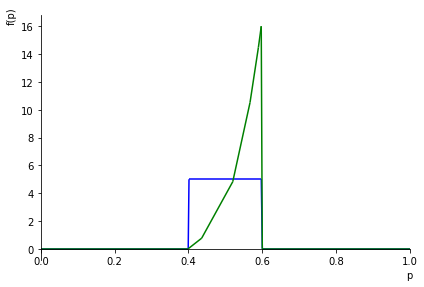

In [3]:
%matplotlib inline
p1 = plot(B_c, xlim=[0,1], show=False, line_color='b')
p2 = plot(likelihood_D * B_c / P_D, show=False, line_color='g')
p1.append(p2[0])
p1.show()

The shape of the graph indicates that we assign a much higher credence to the coin favoring heads than before. But we also assign a probability of $0$ to the value that seems to match the data best $p={15\over 20}$. Is that correct? Generally speaking, we don't want to assign a probability of literally $0$ unless we think it's literally impossible.

We could fix this with some more complicated prior. What kind of properties would we want from such a prior? 

1. Ideally it would be a function of two values $B_{H,T}$, where $H$ and $T$ are the number of heads and tails respectively. 
2. As the number of trials tends to infinity, it should assign almost all of the probability density around $p={H \over H+T}$.
3. If we have a prior of $B_{H_0,T_0}$, and we see $H$ heads and $T$ tails, our posterior would be $B_{H_0 + H, T_0 + T}$.

As it turns out, there is a distribution called the [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution) which satisfies all of these. Usually written $\textrm{Beta}(H, T)$, though it's important to remember, that this is a _distribution_ of possible probability values, i.e. a function $[0,1]\to\mathbb{R}_{\geq 0}$. It's the unique distribution which has all the nice properties you'd want for a binomial likelihood function (called a ["conjugage prior" to the likelihood](https://en.wikipedia.org/wiki/Conjugate_prior)). Other likelihoods have different conjugate priors. To pick out a prior that applies for your domain, you can either start with some existing data, or play around with an interactive tool until you have a distribution that matches your best guess. 

A good prior to start out with if you are going to be able to collect a bunch of data is an _uninformative prior_ like the uniform $\textrm{Beta}(1, 1)$. In our example above, if we'd started out with an uninformative prior:

p**15*(1 - p)**5/beta(16, 6)

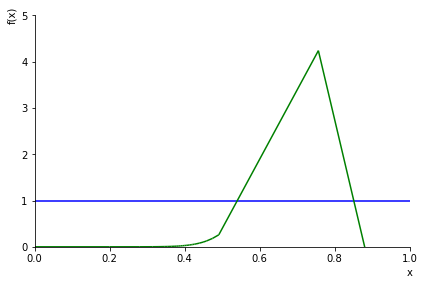

In [4]:
from sympy.stats import Beta, density
alpha_0, beta_0 = 1, 1
prior = density(Beta('prior', alpha_0, beta_0))(p)
posterior = density(Beta('posterior', alpha_0+15, beta_0+5))(p)
display(posterior)
p1 = plot(prior, xlim=[0,1], ylim=[0, 5], show=False, line_color='b')
p2 = plot(posterior, show=False, line_color='g')
p1.append(p2[0])
p1.show()

We can also do the update "manually" by integrating as above, and we should get a similar graph:

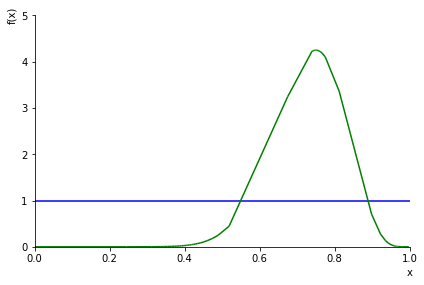

In [5]:
p, N = symbols("p N")

likelihood = sympy.binomial(20, 15) * p** 15 * (1-p)**5
P_D = integrate(prior * likelihood_D, (p, 0, 1))
p1 = plot(prior, xlim=[0,1], ylim=[0, 5], show=False, line_color='b')
p2 = plot(likelihood_D * prior / P_D, show=False, line_color='g')
p1.append(p2[0])
p1.show()